# Imports

In [471]:
# some basic imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from scipy.stats import ttest_ind
import json
import seaborn as sns
import csv
from statsmodels.stats import diagnostic
from pylab import *

# Two additional imports are required; math for the rounding function .ceil(), and scipt.stats for chi2 testing
import math
from scipy.stats import chi2_contingency

# Data Loading

In [472]:
# data path
DATA = './data/'

# movie metadata loading
df_movies = pd.read_csv(DATA + 'movie.metadata.tsv', sep='\t', header=None)
df_movies.columns = ['wikipedia_id', 'freebase_id', 'title', 'release_date', 'revenue', 
                     'runtime', 'spoken_languages', 'countries', 'genres']

# charcaters metadata loading
df_characters = pd.read_csv(DATA + 'character.metadata.tsv', sep='\t', header=None)
df_characters.columns = ['wikipedia_id', 'freebase_id', 'release', 'character_name', 'actor_birth',
                     'actor_gender', 'actor_height', 'actor_ethnicity', 'actor_name', 
                     'age_at_release', 'freebase_map', 'freebase_character_id', 'freebase_actor_id']

# plot summaries
df_plots = pd.read_csv(DATA + 'plot_summaries.txt', sep='\t', header=None, names=['wikipedia_id', 'plot_summary'])

# TMDB dataset (external)
df_tmdb = pd.read_csv(DATA + 'TMDB_movie_dataset_v11.csv')

In [473]:
# merging movie metadata and TMDB
df_movies_tmdb = pd.merge(df_movies, df_tmdb, on='title', how = 'inner')

# Initial Cleaning

In [474]:
# cleaning the text of the movies' spoken langauge, countries, and genres attributes
def cleaning_fct(pattern):
    if pd.isna(pattern) or pattern == '{}':
        return None
    else:
        dict = json.loads(pattern)
        pattern = list(dict.values())
        return pattern

df_movies_tmdb['spoken_languages_x'] = df_movies_tmdb['spoken_languages_x'].apply(cleaning_fct)
df_movies_tmdb['countries'] = df_movies_tmdb['countries'].apply(cleaning_fct)
df_movies_tmdb['genres_x'] = df_movies_tmdb['genres_x'].apply(cleaning_fct)

In [475]:
# duplicate columns have appeared, must drop duplicate with more missing data and then rename
df_movies_tmdb = df_movies_tmdb.drop(['spoken_languages_y'], axis = 1).rename(columns={"spoken_languages_x": "spoken_languages"}) 
df_movies_tmdb = df_movies_tmdb.drop(['genres_y'], axis = 1).rename(columns={"genres_x": "genres"}) 

In [476]:
# use the release date of the TMDB ID dataset to fill the release date of a movie if not present in CMU dataset
df_movies_tmdb["release_date_x"] = df_movies_tmdb['release_date_x'].fillna(df_movies_tmdb['release_date_y'])
df_movies_tmdb = df_movies_tmdb.dropna(subset=['release_date_x'])

# clean missing values in release_date and clean dates to keep the release year only (first four digits of the attribute)
df_movies_tmdb = df_movies_tmdb.drop(['release_date_y'], axis = 1)
df_movies_tmdb = df_movies_tmdb.rename(columns={"release_date_x": "release_date"}) 
df_movies_tmdb['release_date'] = df_movies_tmdb['release_date'].str[:4].astype(int)

# remove movies with no genre reported
df_movies_tmdb = df_movies_tmdb.dropna(subset=['genres'])

# Merging Ratings

Ratings on movies obtained from: https://grouplens.org/datasets/movielens/
--> The 25M dataset at the very bottom of the page is used. Download:\
\
movies.csv as ratings_movies.csv\
ratings.csv as ratings_ratings.csv\
links.csv as ratings_links.csv\

In [477]:
df_ratings_movies = pd.read_csv(DATA + 'ratings_movies.csv', sep=',')

# remove year from titles
df_ratings_movies["title"] = df_ratings_movies["title"].replace(r"[(].+$", "", regex=True)

# determine how many of these movies match with our movies
df_movies_ratings_combined = pd.merge(df_movies, df_ratings_movies, left_on='title', right_on='title')

In [478]:
df_ratings_link = pd.read_csv(DATA + 'ratings_links.csv', sep=',')
df_movies_tmdb_link = df_movies_tmdb

# some films have missing IMDB IDs
df_movies_tmdb_link = df_movies_tmdb_link.dropna(subset=["imdb_id"])
df_movies_tmdb_link = df_movies_tmdb_link.drop(df_movies_tmdb_link[df_movies_tmdb_link["imdb_id"] == 'nan'].index)

# IMDB references in df_movies_TMBD are formatted differently than in df_ratings_link
df_movies_tmdb_link["imdb_id"] = df_movies_tmdb_link["imdb_id"].apply(lambda x: str(x))
df_movies_tmdb_link["imdb_id"] = df_movies_tmdb_link["imdb_id"].apply(lambda x: x.replace("tt", ''))
df_movies_tmdb_link["imdb_id"] = df_movies_tmdb_link["imdb_id"].apply(lambda x: int(x))

# retrieving ratings
df_ratings_ratings = pd.read_csv(DATA + 'ratings_ratings.csv', sep=',')
mean_ratings = df_ratings_ratings.groupby(df_ratings_ratings["movieId"]).mean()
mean_ratings = mean_ratings.rename({'rating': 'mean_rating', 'timestamp': 'mean_rating_timestamp'}, axis=1)

# merge the average ratings to their movies in the ratings linker file
df_ratings_linked = pd.merge(df_ratings_link, mean_ratings, left_on='movieId', right_on='movieId')

# now merge the ratings to the movies and TMDB dataset
df_movies_TMDB_ratings = pd.merge(df_movies_tmdb_link, df_ratings_linked, left_on='imdb_id', right_on='imdbId')

unique_ratings = len(df_movies_TMDB_ratings["title"].unique())
print(f"There are {unique_ratings} unique movies in our movies dataset that have ratings given by the found dataset.")

There are 25355 unique movies in our movies dataset that have ratings given by the found dataset.


In [479]:
# binning ratings to match viewers regular rating style may be useful
df_movies_TMDB_ratings['mean_rating_binned'] = df_movies_TMDB_ratings.mean_rating.mul(2).round().div(2)

# Further cleaning

In [480]:
# keeping wikipedia ID incase we want to merge to characters; dropping many other useless columns
df_movies_TMDB_ratings = df_movies_TMDB_ratings.drop(['freebase_id'], axis = 1)
df_movies_TMDB_ratings = df_movies_TMDB_ratings.drop(['id'], axis = 1)
df_movies_TMDB_ratings = df_movies_TMDB_ratings.drop(['status'], axis = 1)
df_movies_TMDB_ratings = df_movies_TMDB_ratings.drop(['vote_average'], axis = 1)
df_movies_TMDB_ratings = df_movies_TMDB_ratings.drop(['vote_count'], axis = 1)
df_movies_TMDB_ratings = df_movies_TMDB_ratings.drop(['backdrop_path'], axis = 1)
df_movies_TMDB_ratings = df_movies_TMDB_ratings.drop(['budget'], axis = 1)
df_movies_TMDB_ratings = df_movies_TMDB_ratings.drop(['homepage'], axis = 1)
df_movies_TMDB_ratings = df_movies_TMDB_ratings.drop(['original_title'], axis = 1)
df_movies_TMDB_ratings = df_movies_TMDB_ratings.drop(['overview'], axis = 1)
df_movies_TMDB_ratings = df_movies_TMDB_ratings.drop(['popularity'], axis = 1)
df_movies_TMDB_ratings = df_movies_TMDB_ratings.drop(['poster_path'], axis = 1)
df_movies_TMDB_ratings = df_movies_TMDB_ratings.drop(['tagline'], axis = 1)
df_movies_TMDB_ratings = df_movies_TMDB_ratings.drop(['keywords'], axis = 1)
df_movies_TMDB_ratings = df_movies_TMDB_ratings.drop(['movieId'], axis = 1)
df_movies_TMDB_ratings = df_movies_TMDB_ratings.drop(['imdbId'], axis = 1)
df_movies_TMDB_ratings = df_movies_TMDB_ratings.drop(['tmdbId'], axis = 1)
df_movies_TMDB_ratings = df_movies_TMDB_ratings.drop(['userId'], axis = 1)
df_movies_TMDB_ratings = df_movies_TMDB_ratings.drop(['adult'], axis = 1)

# keep metadata from the provided movies dataset source (e.g. CMU datasource)
df_movies_TMDB_ratings = df_movies_TMDB_ratings.drop(['revenue_y'], axis = 1)
df_movies_TMDB_ratings = df_movies_TMDB_ratings.drop(['runtime_y'], axis = 1)

df_movies_TMDB_ratings = df_movies_TMDB_ratings.rename({'revenue_x': 'revenue', 'runtime_x': 'runtime'}, axis=1)

# Filling columns

In [481]:
# filling runtime values with means is required as the data is normal
df_movies_TMDB_ratings = df_movies_TMDB_ratings.fillna({"runtime": df_movies_TMDB_ratings["runtime"].mean()})

In [482]:
# replace the outliers in the runtime column with mean of non-outliers; assuming normality, apply +/- 1.5*IQR of quantiles method

# calculate IQR for runtime
Q1 = df_movies_TMDB_ratings['runtime'].quantile(0.25)
Q3 = df_movies_TMDB_ratings['runtime'].quantile(0.75)
IQR = Q3 - Q1

# identify outliers versus non-outliers for runtime
threshold = 1.5
runtime_outliers = df_movies_TMDB_ratings[(df_movies_TMDB_ratings['runtime'] < Q1 - threshold * IQR) | (df_movies_TMDB_ratings['runtime'] > Q3 + threshold * IQR)]
df_movies_TMDB_ratings = df_movies_TMDB_ratings[~((df_movies_TMDB_ratings['runtime'] < Q1 - threshold * IQR) | (df_movies_TMDB_ratings['runtime'] > Q3 + threshold * IQR))]

# replace the runtime outliers with the mean of non-runtime outliers
runtime_outliers['runtime'] = df_movies_TMDB_ratings['runtime'].mean()

# put these fixed rows into the original dataframe
df_movies_TMDB_ratings = pd.concat([df_movies_TMDB_ratings, runtime_outliers], ignore_index=True)

# revenue filling will be dealt with later

# Genre explosion

At this point, the movies dataset has been expanded upon to include new attributes, such as mean movie rating. Our analysis is heavily dependent on movie genre, hence movies assigned more than one genre must be considered.

In [483]:
# the movies dataset is divided into films with 3 or less versus 4 or more genres in their list of genres
df_movies_TMDB_ratings_short = df_movies_TMDB_ratings[df_movies_TMDB_ratings.genres.map(len) <= 3]
df_movies_TMDB_ratings_long = df_movies_TMDB_ratings[df_movies_TMDB_ratings.genres.map(len) >= 4]

# movies with four or more genres are expanded into numerous movie entries
df_movies_TMDB_ratings_long = df_movies_TMDB_ratings_long.explode("genres")

# only the top 80 exploded movie genres are considered
genres_counts = df_movies_TMDB_ratings_long.groupby("genres").size()
genres_counts = genres_counts.sort_values(axis=0, ascending=False)
genres_counts_top = genres_counts.head(80)

# the quantity of movies represented by the top 80 genres are considered
top_genres_count = genres_counts_top.sum()
all_genres_count = genres_counts.sum()
print(f"The top 80 exploded genres in the movies dataset account for {round(top_genres_count/all_genres_count * 100)}% of all such genres.")

# the quantity of movies represented by the top 80 genres are considered
top_exploded_genres = genres_counts_top.index.tolist()
df_movies_TMDB_ratings_long = df_movies_TMDB_ratings_long[df_movies_TMDB_ratings_long["genres"].isin(top_exploded_genres)]

df_movies_ratings_final = pd.concat([df_movies_TMDB_ratings_short, df_movies_TMDB_ratings_long], ignore_index=True)

The top 80 exploded genres in the movies dataset account for 90% of all such genres.


# Revenue Hardcopies

In [484]:
# revenues is the remaining quantitative column that needs further cleaning due to 68% of entries missing values for this attribute
df_movies_TMDB_ratings_wo_revenue = df_movies_ratings_final
df_movies_TMDB_ratings_wo_revenue = df_movies_TMDB_ratings_wo_revenue.drop(['revenue'], axis = 1)

df_movies_TMDB_ratings_w_revenue = df_movies_ratings_final
df_movies_TMDB_ratings_w_revenue = df_movies_TMDB_ratings_w_revenue.dropna(subset=['revenue'])

# General statistics

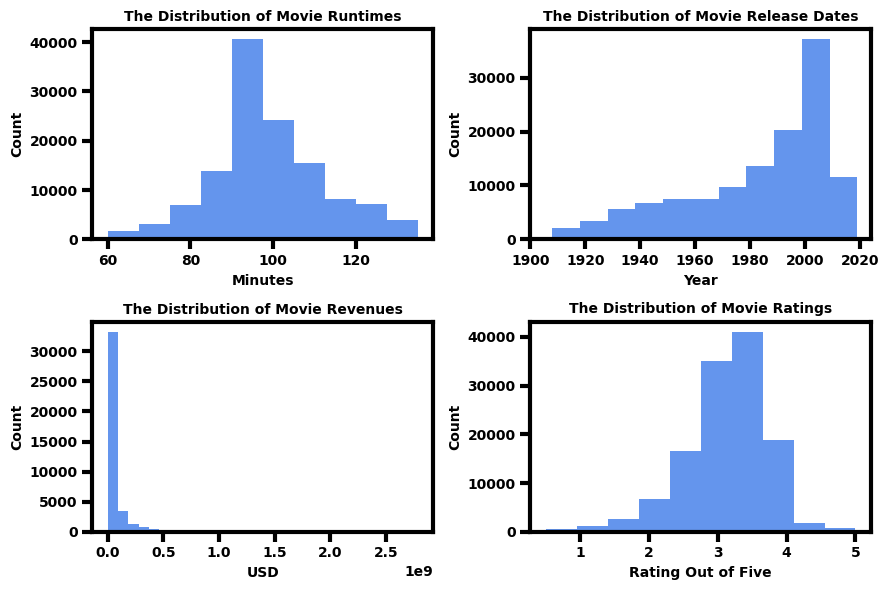

In [485]:
# the standard for our plots; bolded labels, sans-serif font, clean color
fig, ax = plt.subplots(2,2,figsize= (9,6), sharey = False, sharex = False)

hfont = {'fontname':'sans-serif'}
rcParams['font.weight'] = 'bold'
rcParams['axes.linewidth'] = 3

quantities = ['runtime', 'release_date', 'revenue', 'mean_rating']
quantities_x = ['Minutes', 'Year', 'USD', 'Rating Out of Five']

sbplt = ax[0,0]
sbplt.hist(df_movies_ratings_final[quantities[0]].values, bins = 10, fill=True, color='cornflowerblue')
sbplt.set_title("The Distribution of Movie Runtimes", **hfont, weight='bold', fontsize=10)
sbplt.set_xlabel(quantities_x[0], weight='bold', fontsize=10)
sbplt.set_ylabel("Count", weight='bold', fontsize=10)
sbplt.tick_params(axis='both', which='major', width=3, size=7)
    
sbplt = ax[0,1]
sbplt.hist(df_movies_ratings_final[quantities[1]].values, bins = 100, fill=True, color='cornflowerblue')
sbplt.set_title("The Distribution of Movie Release Dates", weight='bold', fontsize=10)
sbplt.set_xlabel(quantities_x[1], weight='bold', fontsize=10)
sbplt.set_ylabel("Count", weight='bold', fontsize=10)
sbplt.set_xlim([1900, 2024])
sbplt.tick_params(axis='both', which='major', width=3, size=7)

sbplt = ax[1,0]
sbplt.hist(df_movies_TMDB_ratings_w_revenue[quantities[2]].values, bins = 30, fill=True, color='cornflowerblue')
sbplt.set_title("The Distribution of Movie Revenues", weight='bold', fontsize=10)
sbplt.set_xlabel(quantities_x[2], weight='bold', fontsize=10)
sbplt.set_ylabel("Count", weight='bold', fontsize=10)
sbplt.tick_params(axis='both', which='major', width=3, size=7)

sbplt = ax[1,1]
sbplt.hist(df_movies_ratings_final[quantities[3]].values, bins = 10, fill=True, color='cornflowerblue')
sbplt.set_title("The Distribution of Movie Ratings", weight='bold', fontsize=10)
sbplt.set_xlabel(quantities_x[3], weight='bold', fontsize=10)
sbplt.set_ylabel("Count", weight='bold', fontsize=10)
sbplt.tick_params(axis='both', which='major', width=3, size=7)

fig.tight_layout()

In [486]:
diagnostic.kstest_normal(df_movies_ratings_final['runtime'].values, dist = 'norm') 

(0.11255244109018042, 0.0009999999999998899)

P < 0.05: Runtime is not normally distributed

In [487]:
diagnostic.kstest_normal(df_movies_TMDB_ratings_w_revenue['revenue'].values, dist = 'exp') 

(0.2742597718903695, 0.0009999999999998899)

P < 0.05: Revenues is not exponentially distributed

In [488]:
diagnostic.kstest_normal(df_movies_ratings_final['mean_rating'].values, dist = 'norm') 

(0.08796521073313263, 0.0009999999999998899)

P < 0.05: Mean ratings is not normally distributed

In [489]:
df_movies_ratings_final["mean_rating"].describe()

count    125318.000000
mean          3.119492
std           0.620178
min           0.500000
25%           2.800000
50%           3.197368
75%           3.514519
max           5.000000
Name: mean_rating, dtype: float64

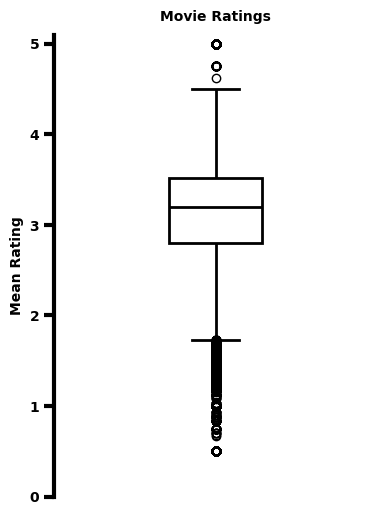

In [490]:
plt.figure(figsize=(4, 6))
ax = sns.boxplot(data=df_movies_ratings_final['mean_rating'], color='white', linewidth=2, linecolor='black', width=0.3)

sns.despine(offset=5, trim=False, bottom=True)
plt.xticks([])
plt.ylim([0,5.1])
plt.title("Movie Ratings", weight='bold', fontsize=10, pad=10)
plt.ylabel("Mean Rating", weight='bold', fontsize=10)
plt.tick_params(axis='both', which='major', width=3, size=7)

fig.tight_layout()

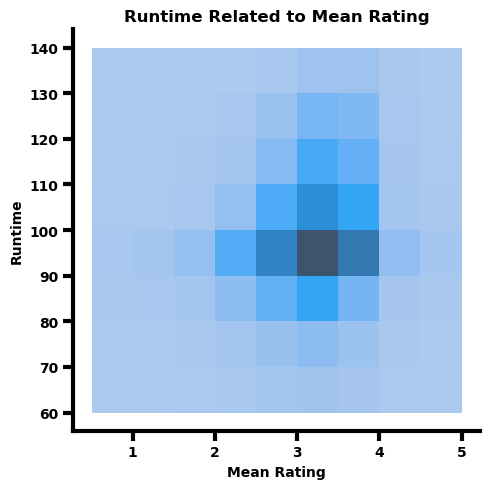

In [491]:
sns.displot(x=df_movies_ratings_final['mean_rating'], y=df_movies_ratings_final['runtime'], binwidth=(0.5, 10))
ax.grid(False)

plt.title("Runtime Related to Mean Rating", weight='bold')
plt.xlabel("Mean Rating", weight='bold', fontsize=10)
plt.ylabel("Runtime", weight='bold', fontsize=10)
plt.tick_params(axis='both', which='major', width=3, size=7)

plt.tight_layout()

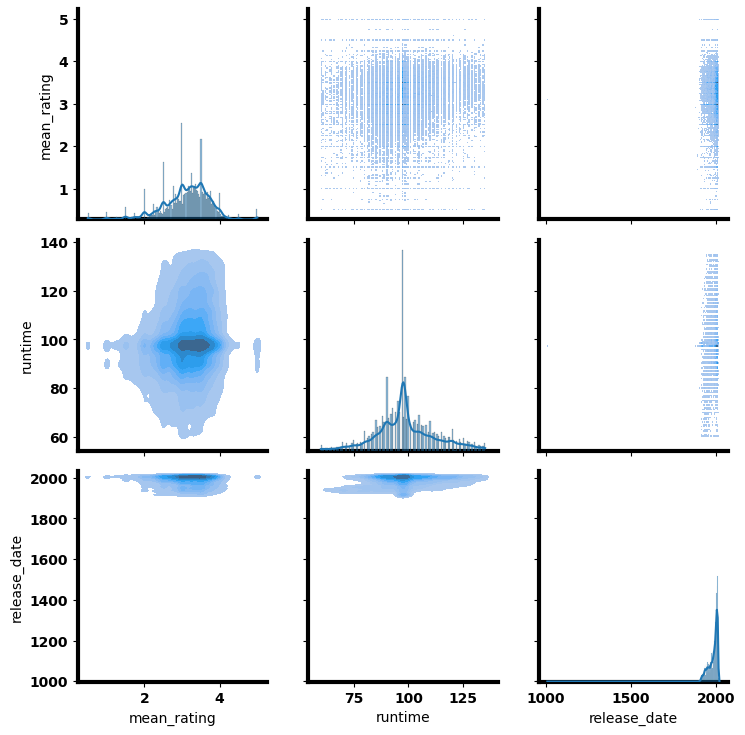

In [492]:
quantitative_variables = ["mean_rating", "runtime", "release_date"]
g = sns.PairGrid(df_movies_ratings_final[quantitative_variables])
g.map_upper(sns.histplot)
g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True)

In [493]:
df_genres_meanratings = pd.crosstab(df_movies_ratings_final['genres'],df_movies_ratings_final['mean_rating_binned'], normalize='index')
sns.heatmap(df_genres_meanratings, annot=False, cmap='viridis')

TypeError: unhashable type: 'list'